In [ ]:
# imports necesarios
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# configuracion del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
if device.type != 'cuda':
    print("ADVERTENCIA: Entrenamiento en CPU será muy lento.")


Usando dispositivo: cuda


In [ ]:
# definicion del modelo con codificacion de fourier
# red neuronal que aprende la distribucion de temperatura
# usa fourier features para capturar cambios bruscos en los bordes del disipador
# los mlp estandar tienen dificultad con altas frecuencias espaciales (spectral bias)
# fourier features mapean las entradas a frecuencias mas altas permitiendo
# que la red capture transiciones abruptas entre material/aire
class FourierPINN(nn.Module):
    def __init__(self):
        super().__init__()
        # matriz de proyeccion de fourier: mapea (x,y,t) a 20 frecuencias aleatorias
        self.B = nn.Parameter(torch.randn(3, 20) * 2.0, requires_grad=False)
        
        # red feedforward: 40 inputs (20 senos + 20 cosenos) -> 1 output (temperatura normalizada)
        self.net = nn.Sequential(
            nn.Linear(40, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        # transformacion de fourier: x -> sin(2πxB) y cos(2πxB)
        x_proj = 2 * np.pi * x @ self.B
        x_fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        
        return self.net(x_fourier)


In [ ]:
# carga de datos y normalizacion
data = np.load("heatsink_data.npz")
params = data["params"]
ALPHA, L_SIZE, T_MAX, T_AMB, T_BASE = params

# factores de normalizacion
X_MAX = L_SIZE
T_MAX_VAL = T_MAX
DELTA_T = T_BASE - T_AMB

# conversion a tensores gpu
def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32).to(device)

X_d = to_tensor(data["X_domain"])
X_b = to_tensor(data["X_boundary"])
T_b = to_tensor(data["T_boundary"])
X_i = to_tensor(data["X_initial"])
T_i = to_tensor(data["T_initial"])

# normalizacion de temperatura a rango [0,1]
T_b_norm = (T_b - T_AMB) / DELTA_T
T_i_norm = (T_i - T_AMB) / DELTA_T

# habilitar gradientes para calcular derivadas
X_d.requires_grad = True


In [ ]:
# funcion de perdida fisica (pde residual)
# calcula cuanto viola la red la ecuacion de calor en puntos del dominio
# usa diferenciacion automatica para calcular derivadas espaciales y temporales
# compara u_t con alpha*(u_xx + u_yy) y penaliza la diferencia
# esto es lo que hace que sea una pinn (physics-informed neural network)
# sin datos en el interior, la fisica guia el aprendizaje
# la ecuacion del calor: dT/dt = alpha * laplacian(T)
# describe como se difunde la temperatura desde zonas calientes a frias
def physics_loss(model, x_in):
    # normalizacion de inputs antes de pasar por la red
    x_norm = x_in.clone()
    x_norm[:, 0:2] = x_norm[:, 0:2] / L_SIZE 
    x_norm[:, 2]   = x_norm[:, 2] / T_MAX_VAL
    
    # prediccion de temperatura normalizada
    u = model(x_norm)
    
    # derivadas de primer orden via autograd
    grads = torch.autograd.grad(u, x_in, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    u_x = grads[:, 0]  # dT/dx
    u_y = grads[:, 1]  # dT/dy
    u_t = grads[:, 2]  # dT/dt
    
    # derivadas de segundo orden (laplaciano)
    u_xx = torch.autograd.grad(u_x, x_in, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]  # d2T/dx2
    u_yy = torch.autograd.grad(u_y, x_in, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]  # d2T/dy2
    
    # residual de la ecuacion de calor: debe ser cero en la solucion real
    # la normalizacion de temperatura se cancela porque la ecuacion es lineal
    res = u_t - ALPHA * (u_xx + u_yy)
    return torch.mean(res ** 2)


Iniciando entrenamiento...


/home/antonio/.local/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 | Loss: 7.78591 | PDE: 0.50776 | Time: 0.5s
Epoch 1000 | Loss: 0.30866 | PDE: 0.10633 | Time: 171.4s
Epoch 2000 | Loss: 0.21393 | PDE: 0.06435 | Time: 336.0s
Epoch 3000 | Loss: 0.18409 | PDE: 0.05128 | Time: 500.0s
Epoch 4000 | Loss: 0.17093 | PDE: 0.04635 | Time: 660.9s
Epoch 5000 | Loss: 0.15709 | PDE: 0.04004 | Time: 821.6s
Epoch 6000 | Loss: 0.15028 | PDE: 0.03745 | Time: 982.4s
Epoch 7000 | Loss: 0.14876 | PDE: 0.03827 | Time: 1149.2s
Epoch 8000 | Loss: 0.13878 | PDE: 0.03290 | Time: 1309.8s
Epoch 9000 | Loss: 0.14052 | PDE: 0.03526 | Time: 1470.5s
Epoch 10000 | Loss: 0.13119 | PDE: 0.03019 | Time: 1630.9s
Epoch 11000 | Loss: 0.12839 | PDE: 0.02916 | Time: 1791.2s
Epoch 12000 | Loss: 0.12690 | PDE: 0.02929 | Time: 1955.5s
Epoch 13000 | Loss: 0.12318 | PDE: 0.02743 | Time: 2115.8s
Epoch 14000 | Loss: 0.12138 | PDE: 0.02709 | Time: 2276.3s
Epoch 15000 | Loss: 0.11900 | PDE: 0.02612 | Time: 2436.7s
Epoch 16000 | Loss: 0.11770 | PDE: 0.02573 | Time: 2597.0s
Epoch 17000 | Loss:

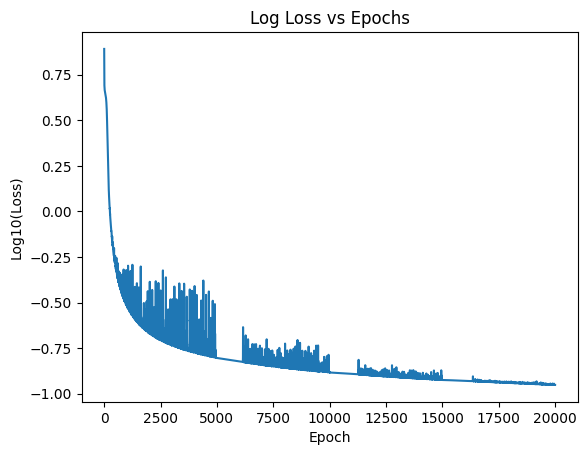

In [ ]:
# configuracion del entrenamiento
model = FourierPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)

EPOCHS = 20000
loss_history = []

print("Iniciando entrenamiento...")
start_time = time.time()

# loop de entrenamiento
# entrena la red para satisfacer 3 restricciones simultaneamente
# combina 3 terminos de perdida con pesos diferentes
# 1. loss_pde: penaliza violar la ecuacion de calor en el dominio interior
# 2. loss_bc: penaliza no cumplir condiciones de frontera (temperatura conocida en bordes)
# 3. loss_ic: penaliza no cumplir condicion inicial (temperatura en t=0)
# las pinn aprenden de la fisica y de datos simultaneamente
# los pesos 10x en bc/ic son necesarios porque:
# - sin ellos, la red ignora las condiciones de contorno
# - el loss pde tiene mas puntos (dominio) que bc/ic (frontera)
# - las bc/ic son "hard constraints" que deben cumplirse exactamente
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # 1. perdida de fisica en el dominio
    loss_pde = physics_loss(model, X_d)
    
    # 2. perdida en condiciones de frontera
    X_b_norm = X_b.clone()
    X_b_norm[:, 0:2] /= L_SIZE
    X_b_norm[:, 2]   /= T_MAX_VAL
    u_pred_b = model(X_b_norm)
    loss_bc = torch.mean((u_pred_b - T_b_norm) ** 2)
    
    # 3. perdida en condicion inicial
    X_i_norm = X_i.clone()
    X_i_norm[:, 0:2] /= L_SIZE
    X_i_norm[:, 2]   /= T_MAX_VAL
    u_pred_i = model(X_i_norm)
    loss_ic = torch.mean((u_pred_i - T_i_norm) ** 2)
    
    # perdida total ponderada
    loss = loss_pde + 10.0 * loss_bc + 10.0 * loss_ic
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    loss_history.append(loss.item())
    
    # monitoreo del progreso
    if epoch % 1000 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch} | Loss: {loss.item():.5f} | PDE: {loss_pde.item():.5f} | Time: {elapsed:.1f}s")
        torch.save(model.state_dict(), f"model_checkpoint_{epoch}.pth")

# guardado del modelo final
torch.save(model.state_dict(), "heatsink_model_final.pth")
print("Entrenamiento finalizado y modelo guardado.")

# visualizacion de convergencia
plt.plot(np.log10(loss_history))
plt.title("Log Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Log10(Loss)")
plt.savefig("loss_curve.png")
plt.show()
